# Tendencia

## ¿Qué es una tendencia?

El componente tendencia de una serie temporal representa un cambio persistente a largo plazo en la media de la serie. La tendencia es la parte más lenta del movimiento de una serie, la parte que representa la mayor escala de tiempo de importancia. En una serie temporal de venta de productos, una tendencia creciente podría ser el efecto de una expansión del mercado a medida que más personas conocen el producto año tras año.

![patrones de tendencias](./images/patrones_tendencia.png)

Aquí nos centraremos en tendencias en la media. Sin embargo, de manera más general, cualquier cambio persistente y de movimiento lento de una serie podría constituir una tendencia. Normalmente, las series temporales tienen tendencias en su variación, por ejemplo.

## Gráficos de media móviles

Para ver qué tipo de tendencia podría tener una serie temporal podemos usar un **gráfico de média móvil**. Para calcular una media móvil de una serie temporal, calculamos la media de los valores dentro de una ventana deslizante de un ancho definido. Cada punto del gráfico representa la media de todos los valores de la serie que se encuentran dentro de la ventada de cada lado. La idea es suavizar cualquier fluctuación a corto plazo en la serie para que solo permanezcan los cambios a largo plazo.

![medias móviles](./images/medias_moviles.gif)

Esta figura muestra una media móvil ilustrando una tendencia lineal. Cada punto de la curva (azul) es la media de los puntos (rojo) dentro de una ventana de tamaño 12.

Observemos cómo la serie *Mauna Loa* tiene un movimiento ascendente y descendente año tras año, un cambio *estacional* a corto plazo. Para que un cambio sea parte de la tendencia debe ocurrir durante un periodo más largo que cualquier cambio estacional. Para visualizar una tendencia, por tanto, tomaremos un promedio durante un periodo más largo que cualquier periodo estacional de la serie. Para la serie *Mauna Loa*, elegimos una ventana de 12 para suavizar la estacionalidad dentro de cada año.

## Ingeniería de tendencias

Una vez que hemos identificado la forma de la tendencia, podemos intentar modelarla usando una variable de paso de tiempo. Ya vimos cómo el uso de una *time dummy* en sí misma modelará una tendencia lineal:

`objetivo = a * time + b`

Podemos ajustar muchos otros tipos de tendencias a través de transformaciones de la *time dummy*. Si la tendencia parece ser cuadrática (una parábola) solo necesitamos añadir el cuadrado de la *time dummy* a la feature, lo que nos daría:

`objetivo = a * time ** 2 + b * time + c`

La regresión lineal aprenderá los coeficientes `a`, `b` y `c`.

Las curvas de tendencia de la siguiente figura se han entrenado usando estos tipos de features y `LinearRegression` de scikit-learn:

![series con tendencias lineales](./images/series_con_tendencias_lineales.png)

La serie superior tendría una tendencia lineal. La serie inferior tendría una tendencia cuadrática.

La regresión lineal puede adaptarse a curvas que no sean líneas. La idea es que si podemos proporcionar curvas de la forma apropiada como features, entonces la regresión lineal puede aprender a combinarlas de la forma que mejor se adapte al objetivo.

## Ejemplo - Tráfico del Túnel

En este ejemplo, crearemos un modelo de tendencia para el dataset de *Tráfico del Túnel*.

In [66]:
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [67]:
import pandas as pd

tunnel = pd.read_csv("../data/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

In [68]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


Hagamos un gráfico de media móvil para ver qué tipo de tendencia tiene esta serie. Dado que esta serie tiene observaciones diarias, elegiremos una ventada de 365 días para suavizar cualquier cambio a corto plazo dentro del año.

Para crar un media móvil, primero usaremos el método `rolling` para empezar el cálculo en la ventana.

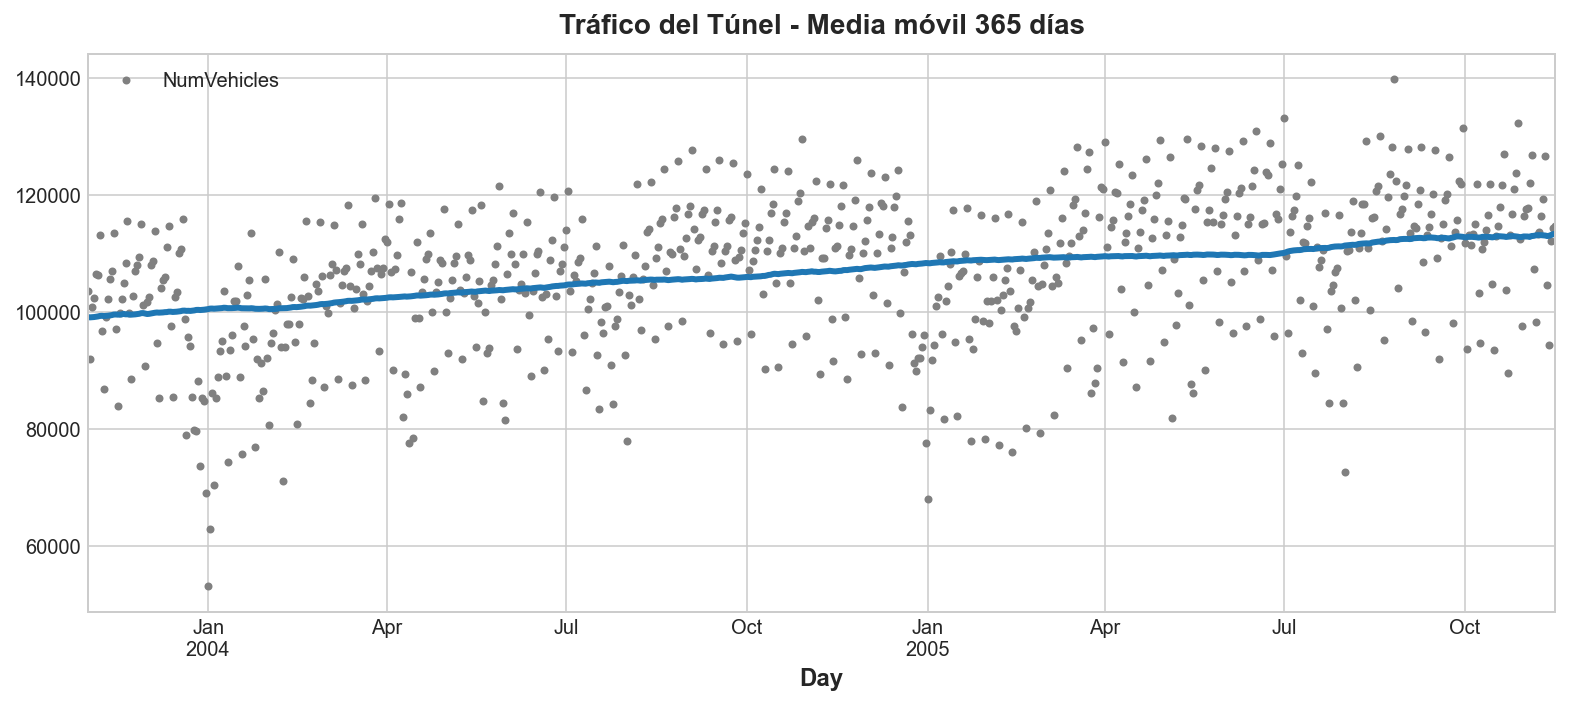

In [69]:
moving_average = tunnel.rolling(
    window=365,       # ventana de 365 días
    center=True,      # pone la media en el dentro de la ventana
    min_periods=183,  # selecciona la mitad del tamaño de la ventana
).mean()              # calcula la media (también podría hacerse la mediana, desviación, mínimo, máximo, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tráfico del Túnel - Media móvil 365 días", legend=False,
);

Como vemos, la tendencia parece ser lineal.

Aunque podemos crear directmente en Pandas nuestra *time dummy*, usaremos una función de la librería `statsmodels` llamada `DeterministicProcess`. Usar esta función nos ayudará a evitar algunos casos de fallos complicados que pueden surgir a veces con las series temporales y la regresión lineal. El argumento `order` se refiere al orden polinomial: `1` para lineal, `2` para cuadrático, `3` cúbico y así sucesivamente.

In [70]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # fechas de los datos de entrenamiento
    constant=True,       # variable dummy para el bias (y_intercept)
    order=1,             # la time dummy (tendencia)
    drop=True,           # elimina términos si es necesario para evitar colinearidad
)
# crea features para las fechas dadas en el argumento `index`
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


Un *proceso determinista* es un término técnico para una serie temporal que no es aleatoria o está completamente determinada, como son `const` y `trend`. Las features derivadas del índice de tiempo serán generalmente deterministas.

Creamos nuestro modelo de tendencia básicamente como antes, aunque tengamos en cuenta la adición del argumento `fit_intercept=False`.

In [71]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # objetivo

# intercept es lo mismo que la variable `const` de DeterministicProcess.
# LinearRegression se comporta mal con features duplicadas,
# así que necesitamos asegurarnos de excluirlas aquí.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

La tendencia descubierta por nuestro modelo `LinearRegression` es casi idéntica a la gráfica de media móvil, lo que sugiere que una tendencia lineal fue la decisión correcta en este caso.

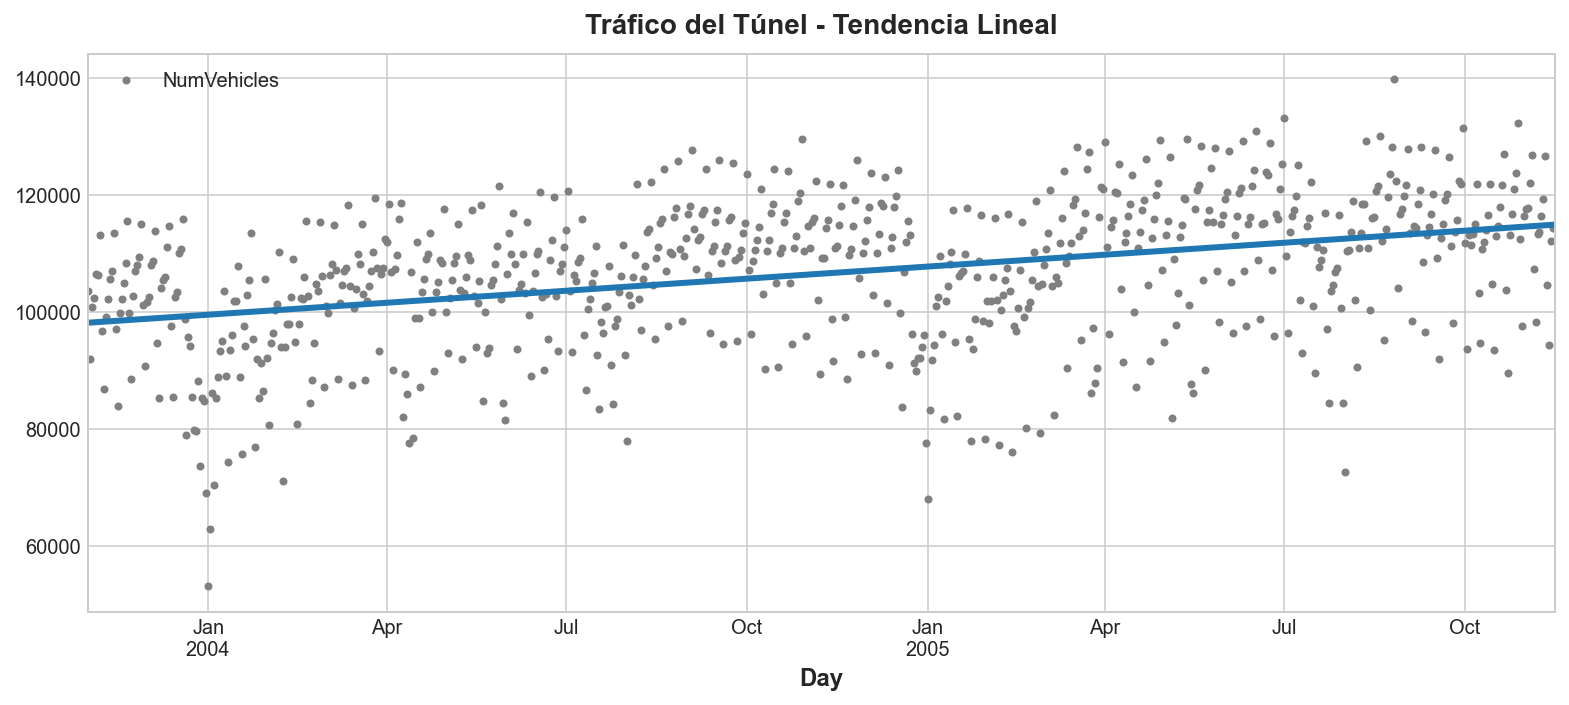

In [72]:
ax = tunnel.plot(style=".", color="0.5", title="Tráfico del Túnel - Tendencia Lineal")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Para hacer un pronóstico, aplicamos nuestro modelo a features "externas". En este caso, "externas" se refiere a fechas fuera del periodo de observación de los datos de entrenamiento. A continuación se muestra cómo sería una predicción a 30 días:

In [73]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Dibujemos una porción de la serie para ver la tendencia del pronóstico para los siguientes 30 días:

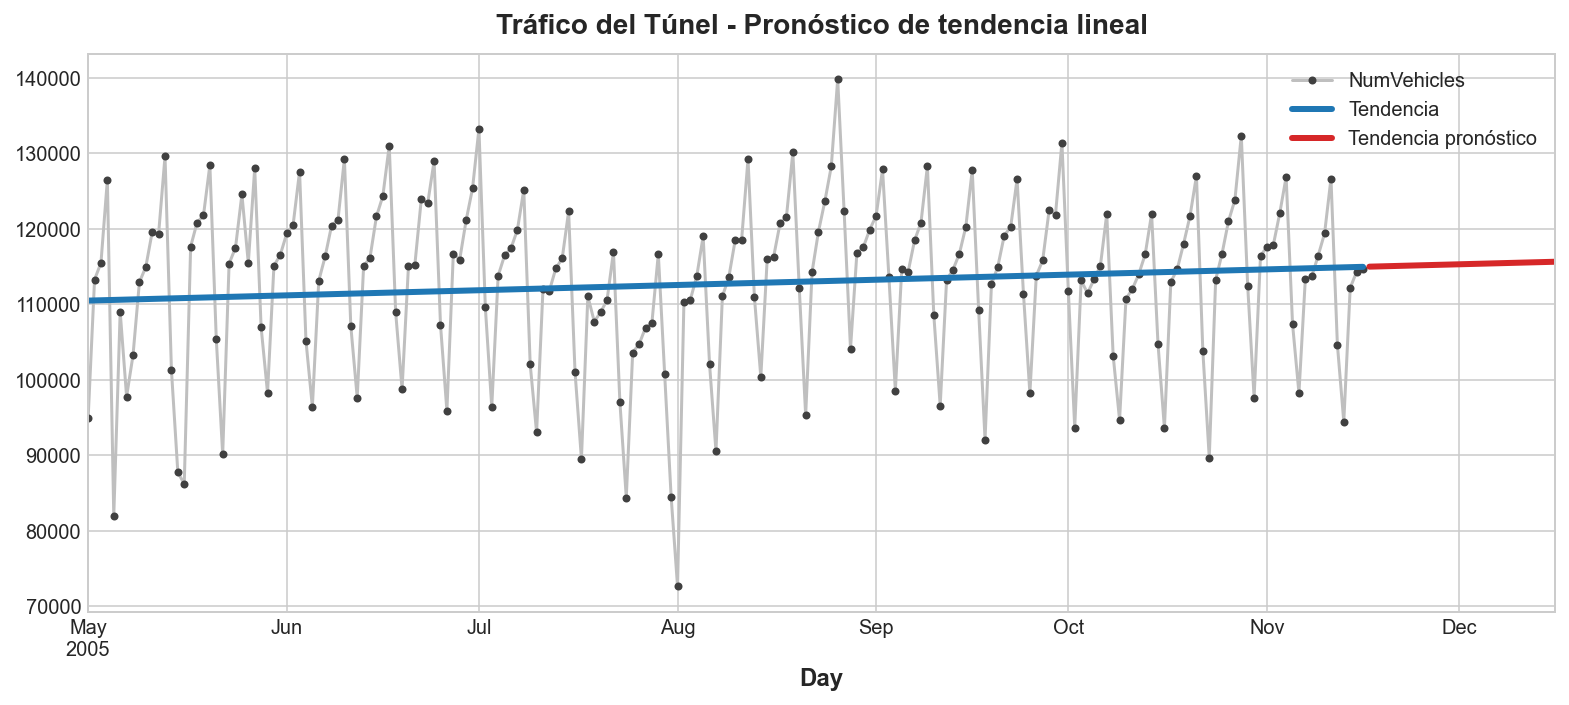

In [74]:
ax = tunnel["2005-05":].plot(title="Tráfico del Túnel - Pronóstico de tendencia lineal", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Tendencia")
ax = y_fore.plot(ax=ax, linewidth=3, label="Tendencia pronóstico", color="C3")
_ = ax.legend()

Los modelos de tendencias que hemos visto son útiles por numerosas razones. Además de actuar como línea base o punto de partida para modelos más sofisticados, también podemos usarlos como un componente en un "modelo híbrido" con algoritmos que nos son capaces de aprender tendencias (como XGBoost y random forest).

# Ejercicio

Vamos a realizar un ejercicio para ampliar lo que acabamos de ver. Para ello cargaremos algunos datasets.

El dataset *US Retail Sales* contiene datos de ventas mensuales para una serie de industrias minoristas de EEUU.

In [75]:
retail_sales = pd.read_csv(
    "../data/us-retail-sales.csv",
    parse_dates=["Month"],
    index_col="Month",
).to_period("D")
food_sales = retail_sales.loc[:, "FoodAndBeverage"]
auto_sales = retail_sales.loc[:, "Automobiles"]

In [76]:
food_sales.head()

Month
1992-01-01    29589
1992-02-01    28570
1992-03-01    29682
1992-04-01    30228
1992-05-01    31677
Freq: D, Name: FoodAndBeverage, dtype: int64

Vamos a dibujar la serie de *Alimentos y Bebidas*.

## Determinar la tendencia con un gráfico de media móvil

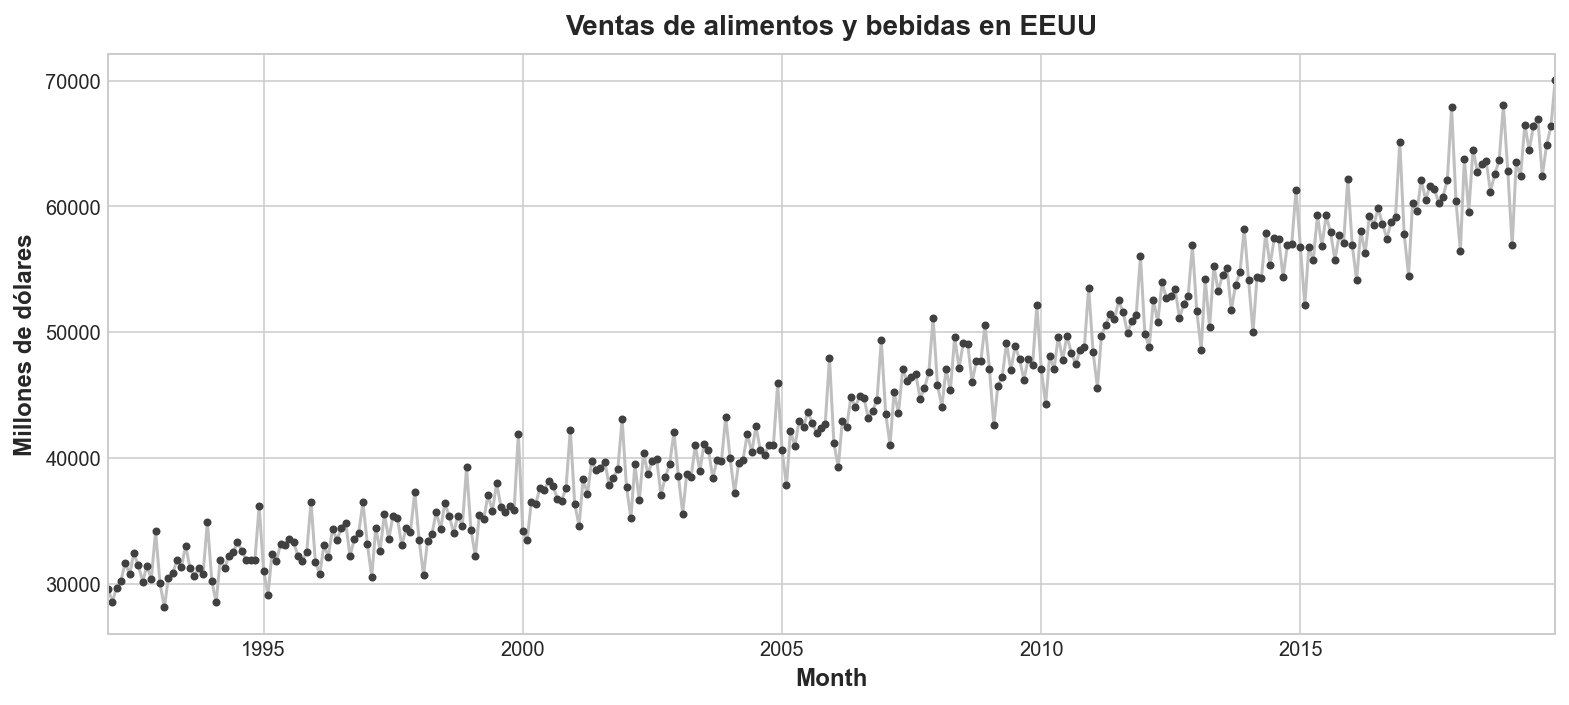

In [77]:
ax = food_sales.plot(**plot_params)
ax.set(title="Ventas de alimentos y bebidas en EEUU", ylabel="Millones de dólares");

Ahora haremos un gráfico de media móvil para estimar la tendencia de esta serie.

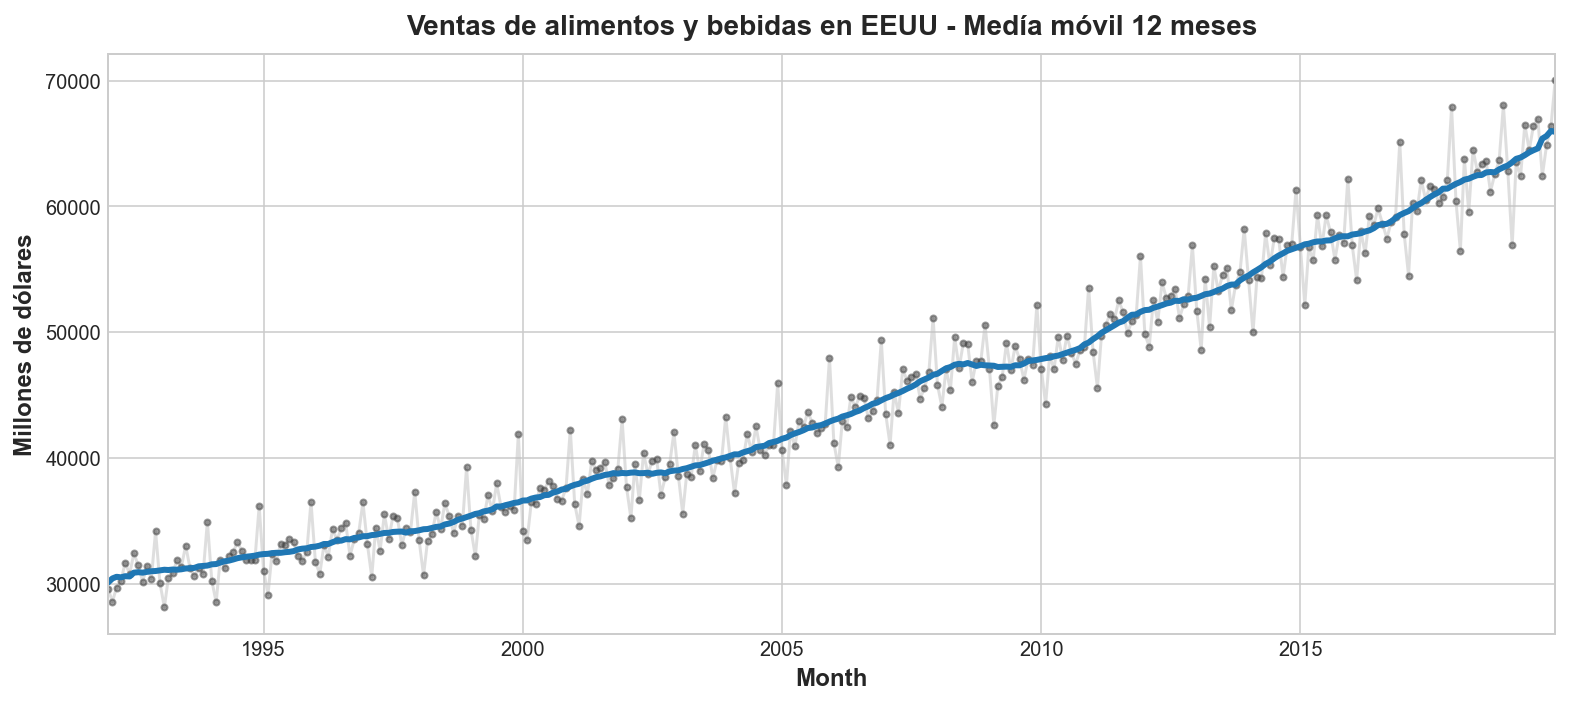

In [78]:
trend = food_sales.rolling(
    window=12,      # ventana de 12 meses
    center=True,    # pone la media en el dentro de la ventana
    min_periods=6,  # selecciona la mitad del tamaño de la ventana
).mean()


# Make a plot
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)
ax.set(title="Ventas de alimentos y bebidas en EEUU - Medía móvil 12 meses", ylabel="Millones de dólares");

## Identificar la tendencia

**¿Qué orden polinomial de la tendencia podría ser adecuado para la serie *Alimentos y Bebidas*? ¿Podríamos pensar en una curva no polinomial que funcionara mejor?**

La curva ascendente de la tendencia sugiere que un polinomio de orden 2 sería el adecuado.

Si se ha trabajado anteriormente con series temporales financieras, se puede suponer que la tasa de crecimiento de la serie Alimentos y Bebidas se expresaría mejor como un cambio porcentual. El cambio porcentual se suele modelar usando una curva exponencial.

## Crear una tendencia futura

In [79]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    "../data/store_sales/train.csv",
    dtype=dtype,
    parse_dates=["date"],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index("date").to_period("D")
store_sales = store_sales.set_index(["store_nbr", "family"], append=True)
average_sales = store_sales.groupby("date").mean()["sales"]

Vamos a dibujar una gráfica de media móvil de `average_sales` estimando la tendencia.

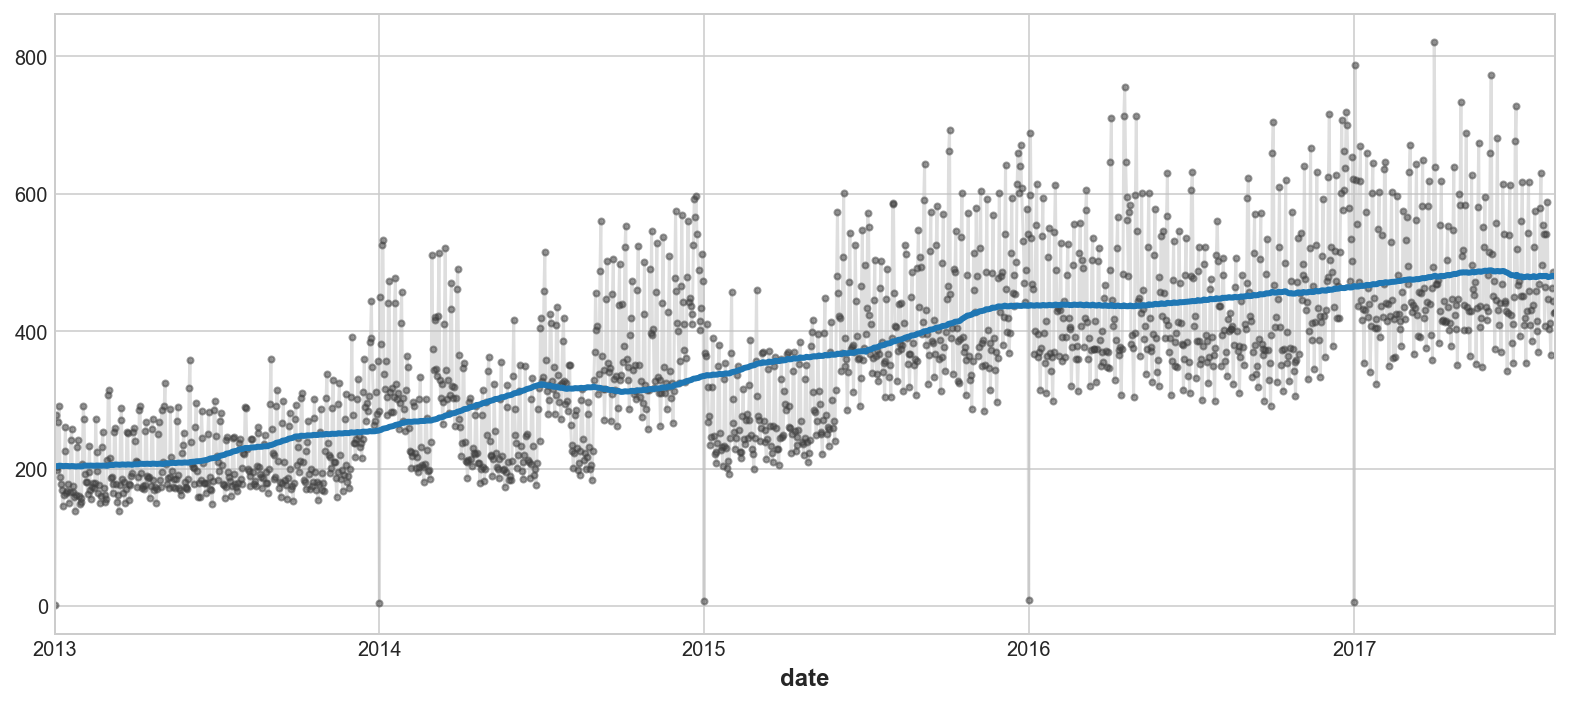

In [80]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

**Usa `DeterministicProcess` para crear un conjunto de features para un modelo de tendencia cúbico. Crea también features para un pronóstico de 90 días**

In [81]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # el objetivo

dp = DeterministicProcess(
    index=y.index,  # fechas de los datos de entrenamiento
    order=3,        # la time dummy (tendencia), cúbica
)

X = dp.in_sample()

X_fore = dp.out_of_sample(90)

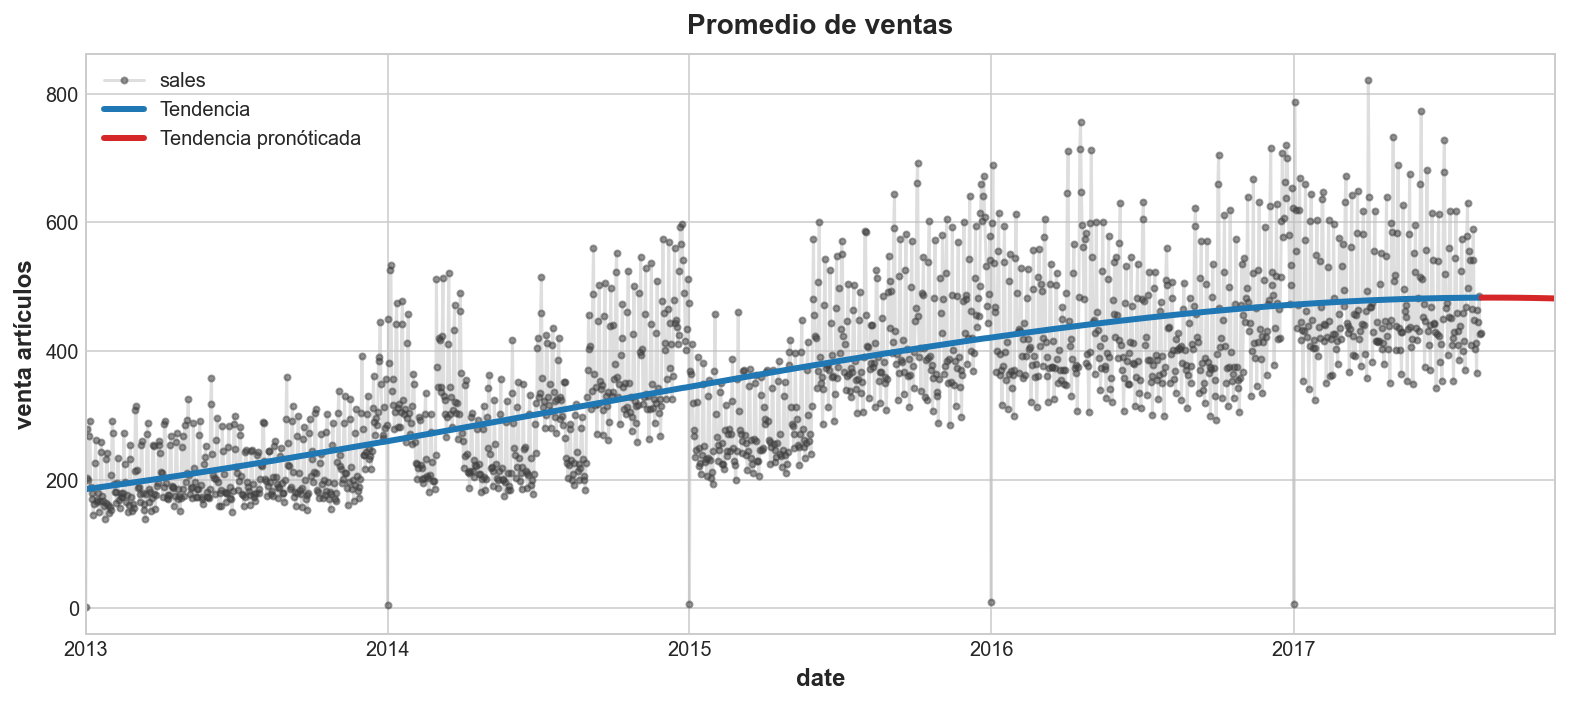

In [82]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Promedio de ventas", ylabel="venta artículos")
ax = y_pred.plot(ax=ax, linewidth=3, label="Tendencia", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Tendencia pronóticada", color='C3')
ax.legend();

## Comprender el riesgo de pronosticar con polinomios de orden alto

Una forma de adaptarse a tendencias más complicadas es incrementar el orden del polinomio usado. Para obtener un mejor ajuste a la tendencia algo complicada de este dataset, podríamos usar un polinomio de orden 11.

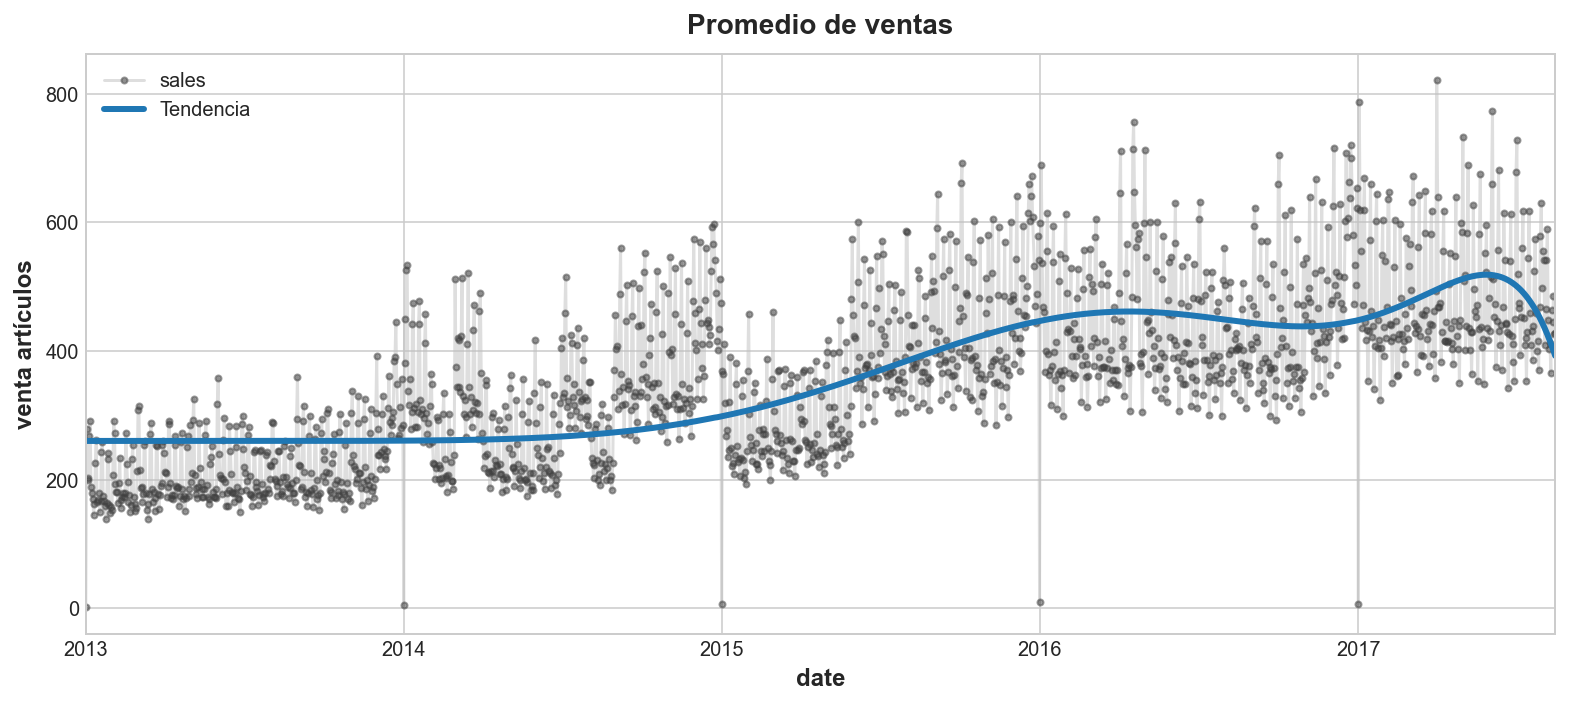

In [83]:
dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Promedio de ventas", ylabel="venta artículos")
ax = y_pred.plot(ax=ax, linewidth=3, label="Tendencia", color='C0')
ax.legend();

Generalmente, los polinomios de orden alto no se adaptan bien a los pronósticos. Un polinomio de orden 11 incluirá términos como `t ** 11`. Términos como éste tienden a divergir rápidamente fuera del periodo de entrenamiento haciendo que los pronósticos sean poco confiables.

Podemos confirmar esta intuición usando un polinomio de grado 11 para el mismo pronóstico que hicimos anteriormente de 90 días.

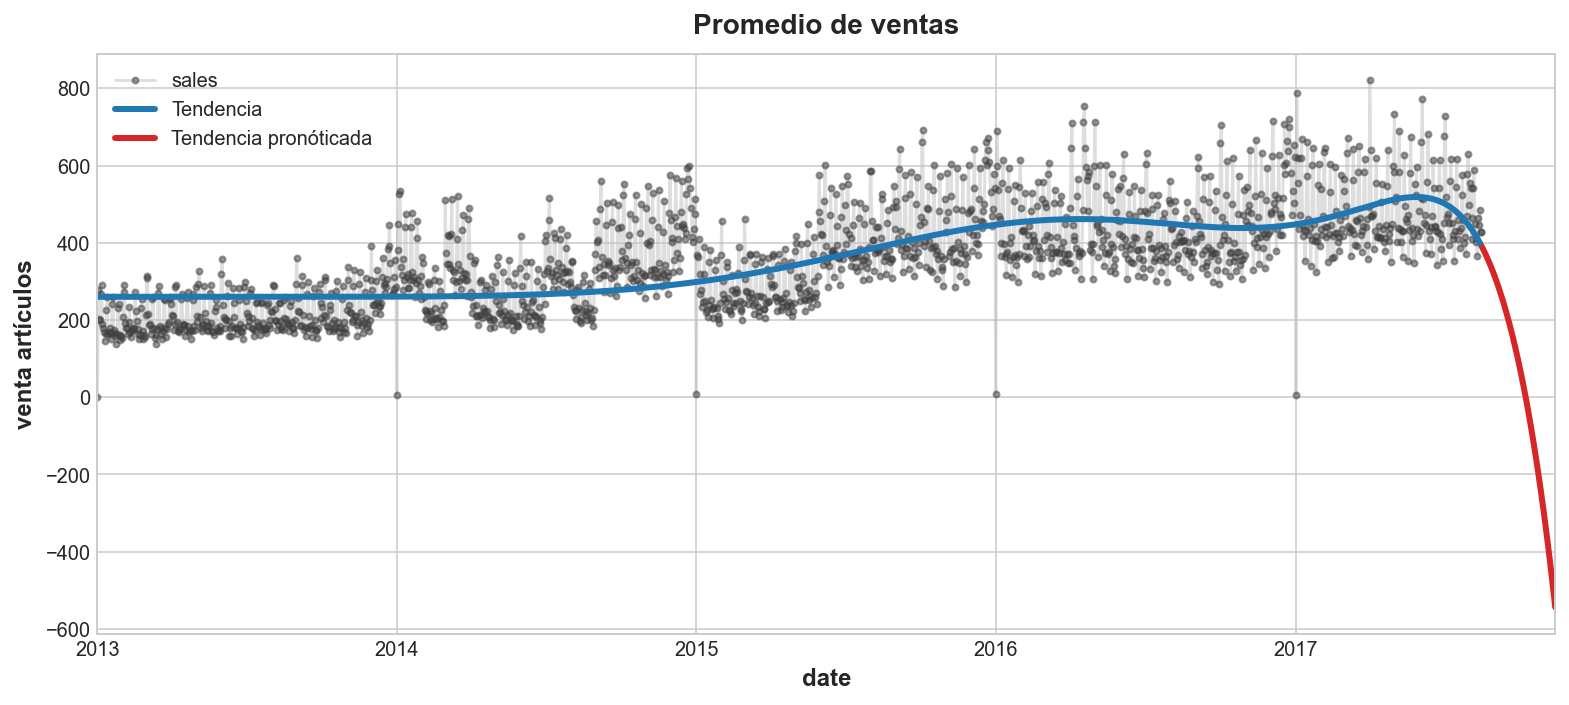

In [84]:
y = average_sales.copy()  # el objetivo

dp = DeterministicProcess(
    index=y.index,  # fechas de los datos de entrenamiento
    order=11,        # la time dummy (tendencia), cúbica
)

X = dp.in_sample()

X_fore = dp.out_of_sample(90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Promedio de ventas", ylabel="venta artículos")
ax = y_pred.plot(ax=ax, linewidth=3, label="Tendencia", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Tendencia pronóticada", color='C3')
ax.legend();